In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.metrics import mean_squared_error

import helper_functions.load_data_helper as mlh

from random_forest import plot_actual_vs_predicted as pavp

import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import ANN

AttributeError: module 'helper_functions' has no attribute 'ml_helpers'

In [2]:
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

def teach_the_terminator(train_features, 
                         train_labels,
                        ml_method):
    
    if ml_method == "Ordinary Least Squares":
        reg = linear_model.LinearRegression()
    if ml_method == "Ridge Regression":
        reg = linear_model.Ridge()
    if ml_method == "Bayesian Regression":
        reg = linear_model.BayesianRidge()
    if ml_method == "Support Vector Machine":
        reg = SVR(kernel='rbf', max_iter = 1000)
    if ml_method == "Stochastic Gradient Descent":
        reg = linear_model.SGDRegressor()
    if ml_method == "K-Nearest Neighbors":
        reg = KNeighborsRegressor()
    if ml_method == "Random Forest":
        reg = RandomForestRegressor()
    if ml_method == "Gradient Boosting":
        reg = GradientBoostingRegressor()
    reg.fit(train_features, train_labels)
    return reg

In [3]:
def run_net(train, 
            test, 
        Nlayers = 3, 
        N_nodes= [10, 5, 1], 
        training_iterations = 1e3, 
        run_name = "", 
        show_comparison = False, 
        nfilters = 27,
        convolution_outsize = 10,
        forward_hops_only = False):

    train_features = train.drop(['chromophoreA', 'chromophoreB', 'TI'], axis=1)
    test_features = test.drop(['chromophoreA', 'chromophoreB', 'TI'], axis=1)
    train_labels = train[['TI']]
    test_labels = test[['TI']]
    test_answers = test_labels
    
    train_features, test_features, train_labels, test_labels = train_features.values, test_features.values, train_labels.values, test_labels.values

    assert Nlayers == len(N_nodes)

    x = tf.placeholder(tf.float32, shape = [None, len(train_features[0])])
    y_ = tf.placeholder(tf.float32, shape = [None, 1])

    layer_dict = {}

    xconv = ANN.convolve(x, nfilters, convolution_outsize)

    for N in range(Nlayers):
        if N == 0:
            layer_dict["layer_{}".format(N)] = tf.nn.elu(ANN.weights(x, convolution_outsize, N_nodes[N]))
        elif N + 1 == Nlayers:
            layer_dict["layer_{}".format(N)] = tf.nn.elu(ANN.weights(layer_dict["layer_{}".format(N-1)], N_nodes[N-1], N_nodes[N]))
        else:
            layer_dict["layer_{}".format(N)] = tf.nn.elu(ANN.weights(layer_dict["layer_{}".format(N-1)], N_nodes[N-1], N_nodes[N]))

    y_out = layer_dict["layer_{}".format(Nlayers-1)]

    cost = tf.losses.huber_loss(labels = y_, predictions = y_out)

    optimizer = tf.train.AdamOptimizer(0.01)
    training_step = optimizer.minimize(cost)

    session = tf.Session()
    session.run(tf.global_variables_initializer())

    training_error = []

    for _ in range(int(training_iterations)):
        batch_vectors, batch_answers = ANN.get_batch(train_features, train_labels)
        session.run(training_step,feed_dict={x:batch_vectors,y_:batch_answers})
        if _ % (int(training_iterations)//10) == 0:

            train_error = session.run(cost,feed_dict={x:train_features,y_:train_labels})
            training_error.append([_, train_error])
            print(train_error)

    pred_y = session.run(y_out, feed_dict={x: test_features})

    mae = np.mean(abs(pred_y-test_labels))

    slope, intercept, r_value, p_value, std_err = stats.linregress(
        test_labels.flatten(), pred_y.flatten()
    )

    return pred_y

In [4]:
def make_plots(actual, predicted, feature, names):
    plt.close()
    colors = feature
    plt.scatter(
        actual, predictions, s=12, alpha=0.5, zorder=0, c=colors, cmap="jet"
    )
    plt.plot(
        np.linspace(0, np.amax(actual), 10),
        np.linspace(0, np.amax(actual), 10),
        c="k",
        zorder=10,
    )
    plt.colorbar()
    plt.ylabel("Predicted TI")
    plt.xlabel("Actual TI")
    plt.title("{}".format(names))
    plt.show()

In [24]:
def analyze_predictions(pred, tests):
    slope, intercept, r_value, p_value, std_err = stats.linregress(tests.values.flatten(), 
                                                                   pred.flatten())
    mae = np.mean(abs(pred.flatten() - tests.values.flatten()))
    return r_value, mae

In [44]:
from matplotlib.colors import LogNorm
from matplotlib import cm

def plot_based_on_density(actual, predicted, system, r_value, mae):
    print("Beginning the Plot.")
    actual = np.array(actual.values).flatten()
    predicted = predicted.flatten()
    
    fig, ax = plt.subplots()
    
    plt.hist2d(actual, predicted, (50, 50), norm=LogNorm(), cmap='viridis')
    plt.colorbar()
    plt.plot(np.linspace(0, np.amax(actual), 10),
            np.linspace(0, np.amax(actual), 10),
            'w--',
            alpha = 0.5)
    plt.xlabel("Actual (eV)")
    plt.ylabel("Predicted (eV)")
    plt.title("{}".format(system))
    plt.text(0.8, 0.1, 
             s=r"R$^{2}$:"+"{:.4f}\nMAE:{:.4f}".format(r_value**2, mae), 
             color = 'w', fontsize = 20)
    rgba = cm.get_cmap('viridis')
    rgba = rgba(0.0)
    ax.set_facecolor(rgba)
    ax.set_xlim([0, np.amax(actual)])
    ax.set_ylim([0, np.amax(predicted)])
    plt.show()
    

In [15]:
def apply_combined(method_name, train, test, plot_scatter=False):
    
    train = train.drop(['chromophoreA', 'chromophoreB'], axis=1)
    test = test.drop(['chromophoreA', 'chromophoreB'], axis=1)
    print(list(train.drop('TI', axis=1)))
    
    reg = teach_the_terminator(train.drop(['TI'], axis=1), 
                               train[['TI']], 
                               method_name)
    predictions = np.array([reg.predict(test.drop(['TI'], axis=1)).T])
    
    if len(predictions.shape) == 3:
        predictions = predictions[0]
        
    print(predictions.T.shape, test[['TI']].shape)
    r_value, mae = analyze_predictions(predictions.T, test[['TI']])

    plot_based_on_density(test[['TI']], predictions, method_name, r_value, mae)
    if plot_scatter:
        pavp(test[['TI']], predictions, r_value, mae, name=method_name)
    
    del reg
    return predictions

In [8]:
train_features, test_features, train_labels, test_labels = mlh.get_data(
    database = 'p3ht_pdi.db',
    training_tables=['ordered_frame_0', 
                     'semiordered_frame_0',
                     'disordered_frame_0',
                    ],
    validation_tables=['semiordered_frame_1'],
    absolute=['rotX', 'rotY', 'rotZ'],
    skip=[],
    yval='TI',
)

Loading data from p3ht_pdi.db...
Separating training and test data...


In [9]:
columns = list(train_features.drop('TI', axis=1))

['bonded', 'deltaE', 'distance', 'posX', 'posY', 'posZ', 'rotX', 'rotY', 'rotZ', 'sulfur_distance']
(241222, 1) (241222, 1)
Beginning the Plot.


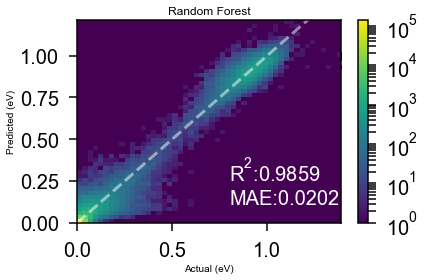

CPU times: user 1min 58s, sys: 1.02 s, total: 1min 59s
Wall time: 1min 56s


In [65]:
%time predictions = apply_combined("Random Forest", train_features, test_features)
results["Random Forest"] = predictions.T